
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Мария Мансурова, аналитик-разработчик в команде Яндекс.Метрики. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [30]:
import os

import pandas as pd
import requests
from itertools import product
from plotly import __version__
from plotly import graph_objs as go
from tqdm import tqdm
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

5.6.0


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv("../data/wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index("date")[["count"]])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
# !pip install prophet

In [7]:
import numpy as np
from prophet import Prophet

In [8]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()
valid_df = df[-predictions:].copy()

In [9]:
model = Prophet()
model.fit(train_df)

15:01:17 - cmdstanpy - INFO - Chain [1] start processing
15:01:17 - cmdstanpy - INFO - Chain [1] done processing


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [10]:
future_dates = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future_dates)

In [11]:
forecast[-1:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
382,2016-01-20,2996.209544,3038.59715,3813.96363,2973.877538,3022.441582,425.537704,425.537704,425.537704,425.537704,425.537704,425.537704,0.0,0.0,0.0,3421.747248


In [12]:
print(f'Предсказание на 20 января: {np.round(forecast[-1:]["yhat"])}')

Предсказание на 20 января: 382    3422.0
Name: yhat, dtype: float64


**Ответ:** 3422

Рассмотрим, что есть в предсказнии модели

In [13]:
pprint(', '.join(forecast.columns))

Pretty printing has been turned OFF


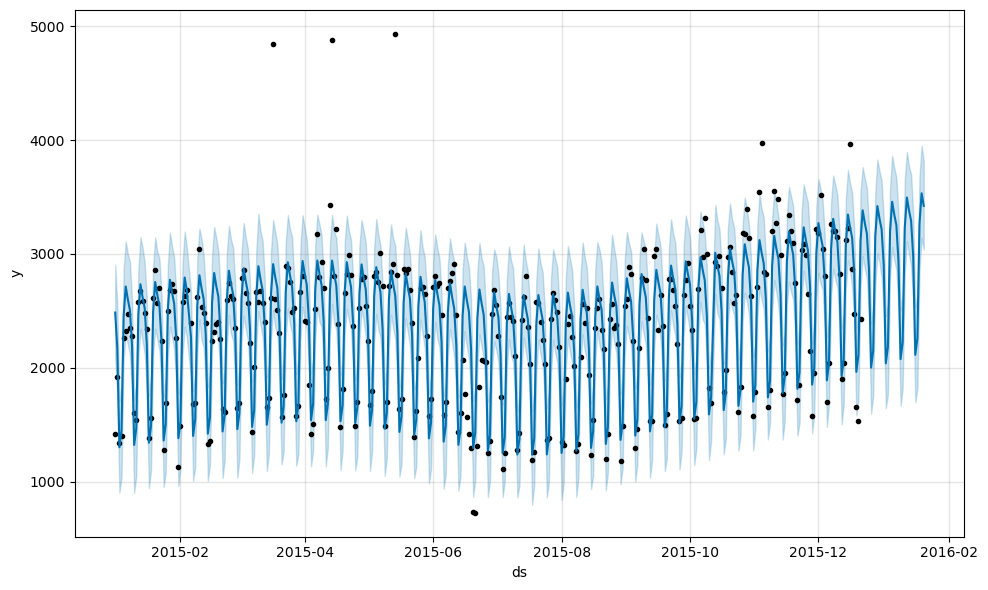

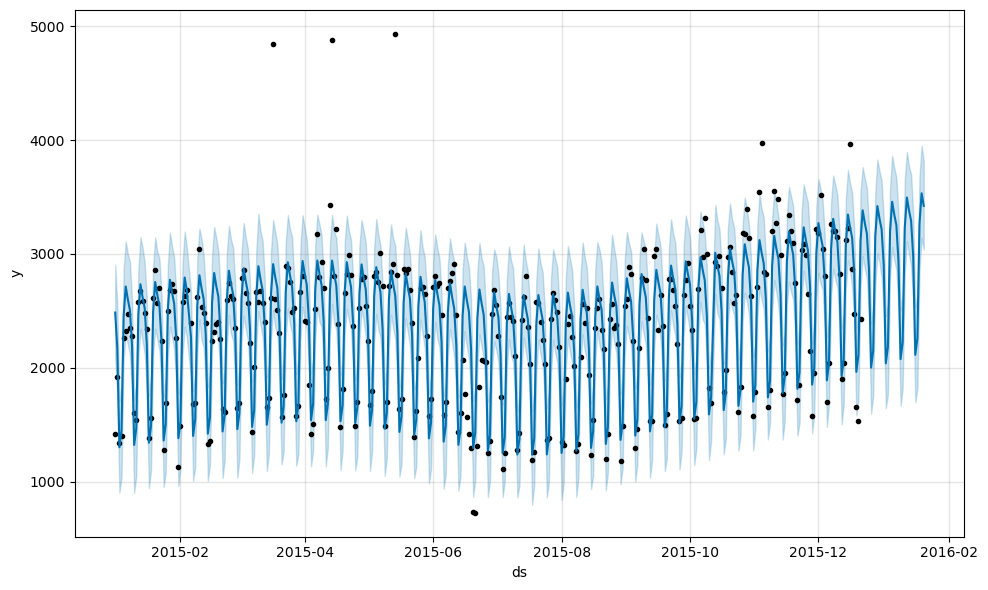

In [14]:
model.plot(forecast)

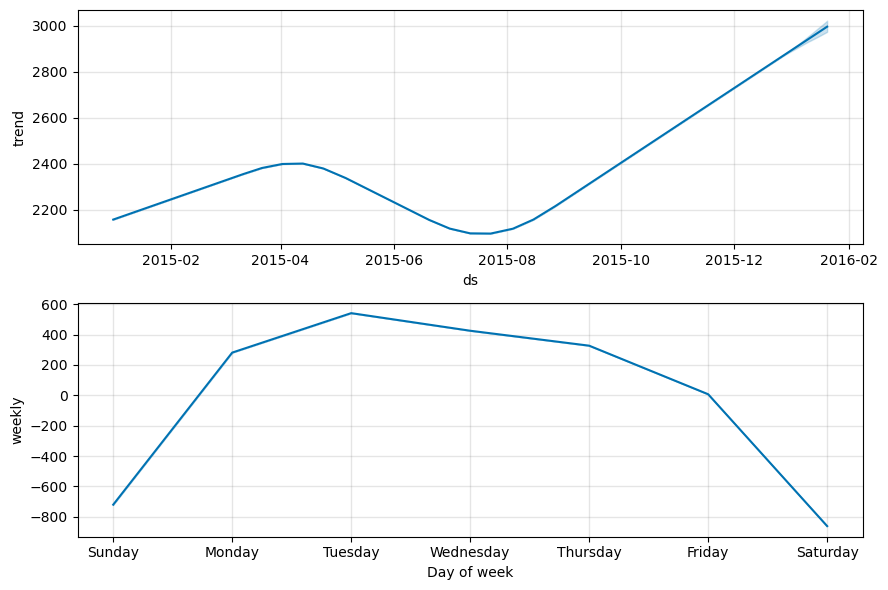

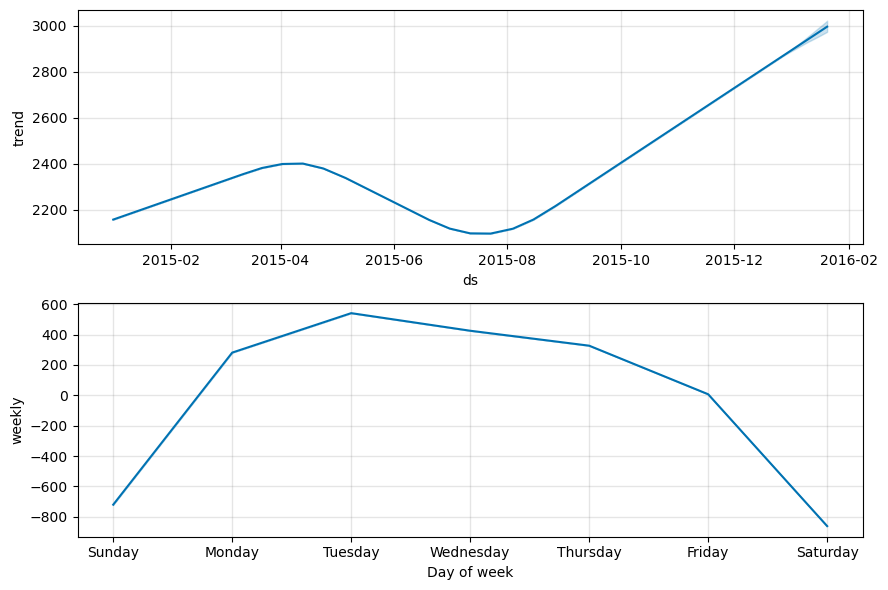

In [15]:
model.plot_components(forecast)

In [16]:
# подсчитаем ошибки по каждому объекту
preds = forecast[-predictions:].set_index('ds')[['yhat']].join(valid_df.set_index('ds'))

preds['absolute_error'] = np.abs(preds['y'] - preds['yhat'])
preds['absolute_percent_error'] = 100 * (preds['absolute_error'] / preds['y'])

In [17]:
preds.tail()

,yhat,y,absolute_error,absolute_percent_error
ds,,,,
2016-01-16,2113.117858,1644,469.117858,28.535150
2016-01-17,2259.438811,1836,423.438811,23.063116
2016-01-18,3266.962677,2983,283.962677,9.519366
2016-01-19,3532.319025,3389,143.319025,4.228947
2016-01-20,3421.747248,3559,137.252752,3.856498


In [18]:
mae = np.mean(preds['absolute_error'])
mape = np.mean(preds['absolute_percent_error'])

print(f'MAE: {np.round(mae, 2)}')
print(f'MAPE: {np.round(mape, 2)}')

MAE: 596.46
MAPE: 34.34


**Вопрос 2**: Какое получилось MAPE?

**Ответ:** 596.46

**Вопрос 3**: Какое получилось MAE?

**Ответ:** 34.34

## Предсказываем с помощью ARIMA

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [20]:
# уровень значимости
alpha = 0.05
p_value = np.round(sm.tsa.stattools.adfuller(train_df['y'])[1], 7)

print(f"Критерий Дики-Фуллера: {p_value};\nРяд стационарен: {p_value < alpha}")

Критерий Дики-Фуллера: 0.1073922;
Ряд стационарен: False


In [21]:
# проведем преобразование Бокса-Кокса

train_df_boxcox = train_df.copy().set_index('ds')
train_df_boxcox['y'], lambda_prophet = stats.boxcox(train_df_boxcox['y'])

In [22]:
# проверим p-value еще раз
p_value = np.round(sm.tsa.stattools.adfuller(train_df_boxcox['y'])[1], 7)

print(f"Критерий Дики-Фуллера: {p_value};\nРяд стационарен: {p_value < alpha}")

Критерий Дики-Фуллера: 0.1169809;
Ряд стационарен: False


Видим, что преобразование Бокса-Кокса не помогло, p-value стало только больше

**Ответ:** ряд не является стационарным; p-value равно 0.1073922

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [59]:
# инициализируем параметры

p = 1
P = 3
d = range(0, 2)
D = range(0, 3)
q = 2
Q = range(0, 2)
s = 12

In [60]:
parameters = product(d, D, Q)
parameters_list = list(parameters)
len(parameters_list)

12

In [61]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(p, param[0], q), 
                                        seasonal_order=(P, param[1], param[2], s)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  8%|██████▉                                                                            | 1/12 [00:09<01:39,  9.03s/it]C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

 50%|█████████████████████████████████████████▌                                         | 6/12 [01:23<01:35, 15.98s/it]C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:03<00:00, 15.3

CPU times: total: 4min 25s
Wall time: 3min 3s


In [72]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters          aic
5   (0, 2, 1)  5133.143437
11  (1, 2, 1)  5146.293487
9   (1, 1, 1)  5191.505712
8   (1, 1, 0)  5191.765206
2   (0, 1, 0)  5236.562484


**Ответ (лучшие параметры):**
- **p** = 1
- **P** = 3
- **d** = 0
- **D** = 2
- **q** = 2
- **Q** = 1
- **s** = 12
